# 📊 BA-02: Planeación S&OP con escenarios de demanda

Modelo simplificado de S&OP que integra demanda pronosticada, capacidad y políticas de servicio para simular escenarios (base/optimista/pesimista) y evaluar backlog, utilización y nivel de servicio.

---\nid: "BA-02"\ntitle: "Planeación S&OP con escenarios de demanda"\nspecialty: "Business Analytics"\nprocess: "Plan"\nlevel: "Intermediate"\ntags: ["sop", "scenarios", "capacity", "backlog", "fill-rate"]\nestimated_time_min: 45\n---\n

In [10]:
# ⚙️ Resolución robusta de rutas
from pathlib import Path
def resolve_repo_root(start: Path) -> Path:
    cur = start
    for _ in range(6):
        if (cur / 'data').exists() and (cur / 'notebooks').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start

root = resolve_repo_root(Path.cwd())
raw_path = root / 'data' / 'raw'
processed_path = root / 'data' / 'processed'
processed_path.mkdir(parents=True, exist_ok=True)

### ⚙️ Preparación de entorno y rutas
Este bloque detecta la raíz del repositorio y define las rutas `data/raw` y `data/processed` para garantizar que el notebook sea ejecutable en VS Code y con papermill.

In [12]:
# 📦 Generación de datos sintéticos si no existen
import pandas as pd
import numpy as np
np.random.seed(42)

weeks = pd.date_range('2025-01-06', periods=12, freq='W-MON')
families = ['A', 'B', 'C']
skus = [f'{fam}{i:02d}' for fam in families for i in range(1, 6)]

# Demanda semanal por SKU (base) con tendencia y variabilidad
dem_base = []
for sku in skus:
    fam = sku[0]
    # Medias más altas para generar tensión vs capacidad
    base_mean = {'A': 140, 'B': 95, 'C': 75}[fam]
    std = {'A': 25, 'B': 18, 'C': 12}[fam]
    # Tendencia creciente (+15% al final del período)
    trend = np.linspace(0.95, 1.15, len(weeks))
    for i, (w, t) in enumerate(zip(weeks, trend)):
        mean_week = base_mean * t
        val = np.clip(np.random.normal(mean_week, std), 0, None).round()
        dem_base.append({'week': w, 'family': fam, 'sku': sku, 'demand': int(val)})
df_dem_base = pd.DataFrame(dem_base)

# Capacidad por período (planta + transporte) - ajustada para forzar trade-offs
df_capacity = pd.DataFrame({
  'week': weeks,
  # Capacidad reducida y con picos/valles para simular restricciones reales
  'prod_capacity': [650, 680, 720, 700, 750, 730, 650, 680, 720, 700, 680, 650],
  'trans_capacity': [550, 570, 600, 580, 620, 600, 550, 570, 600, 580, 570, 550]
})
df_capacity['total_capacity'] = df_capacity['prod_capacity'] + df_capacity['trans_capacity']

# Fill rate objetivo por familia
df_policies = pd.DataFrame({
  'family': families,
  'fill_rate_target': [0.95, 0.90, 0.88]
})

df_dem_base.to_parquet(processed_path / 'sop_dem_base.parquet', index=False)
df_capacity.to_parquet(processed_path / 'sop_capacity.parquet', index=False)
df_policies.to_parquet(processed_path / 'sop_policies.parquet', index=False)
df_dem_base.head(), df_capacity.head(), df_policies

(        week family  sku  demand
 0 2025-01-06      A  A01     145
 1 2025-01-13      A  A01     132
 2 2025-01-20      A  A01     154
 3 2025-01-27      A  A01     179
 4 2025-02-03      A  A01     137,
         week  prod_capacity  trans_capacity  total_capacity
 0 2025-01-06            650             550            1200
 1 2025-01-13            680             570            1250
 2 2025-01-20            720             600            1320
 3 2025-01-27            700             580            1280
 4 2025-02-03            750             620            1370,
   family  fill_rate_target
 0      A              0.95
 1      B              0.90
 2      C              0.88)

### 📦 Generación de datos sintéticos
Se construyen demanda semanal por SKU/familia (con ruido), capacidad total (producción + transporte) y políticas de servicio (fill rate objetivo). Se persisten en `data/processed` para reutilización.

- Semilla fija: Se establece `np.random.seed(42)` para asegurar reproducibilidad.
- Demanda: Generada por familia con medias y desvíos distintos, luego recortada a valores no negativos.
- Capacidad: `total_capacity = prod_capacity + trans_capacity` por semana.
- Políticas: `fill_rate_target` por familia para comparar desempeño.

## 🎛️ Definición de escenarios
- Base: demanda observada
- Optimista: +10% demanda
- Pesimista: -10% demanda

## 📋 Qué - Por qué - Para qué - Cuándo - Cómo

### ❓ Qué
Simular S&OP semanal por familia con capacidad total y políticas de servicio.

### 🔍 Por qué
Visibilizar impacto de escenarios de demanda en backlog, utilización y nivel de servicio.

### 🎯 Para qué
Apoyar decisiones de nivel de producción/transporte y compromisos de servicio.

### ⏰ Cuándo
Ciclos S&OP semanales/mensuales, ajuste de capacidad o promociones.

### 🛠️ Cómo
Datos sintéticos, agregación por semana/familia, asignación por prioridades y cálculo de KPIs.

## 📚 Resumen y Próximos pasos
1. Modelo S&OP ejecutable con escenarios base/optimista/pesimista.
2. KPIs de backlog, utilización y nivel de servicio por familia.
3. Exportes en `data/processed/sop_scenarios/`.

Próximos pasos: agregar visualizaciones (líneas para backlog y barras para fill rate) y sensibilidad de capacidad.

In [13]:
# Construcción de escenarios
def build_scenario(df_dem, name, factor):
    s = df_dem.copy()
    s['scenario'] = name
    s['demand'] = (s['demand'] * factor).round().astype(int)
    return s

sc_base = build_scenario(df_dem_base, 'base', 1.00)
sc_opt = build_scenario(df_dem_base, 'optimista', 1.10)
sc_pes = build_scenario(df_dem_base, 'pesimista', 0.90)
df_dem_scen = pd.concat([sc_base, sc_opt, sc_pes], ignore_index=True)
df_dem_scen.head()

,week,family,sku,demand,scenario
0,2025-01-06,A,A01,145,base
1,2025-01-13,A,A01,132,base
2,2025-01-20,A,A01,154,base
3,2025-01-27,A,A01,179,base
4,2025-02-03,A,A01,137,base


### 🎛️ Construcción de escenarios de demanda
Se generan tres escenarios: base (1.00), optimista (+10%) y pesimista (-10%) para analizar sensibilidad en backlog, utilización y nivel de servicio.

In [14]:
# Agregación y simulación semana a semana
import pandas as pd

dem_week_family = df_dem_scen.groupby(['scenario', 'week', 'family'], as_index=False)['demand'].sum()
priority = ['A', 'B', 'C']
records = []

for scen in dem_week_family['scenario'].unique():
    backlog = {fam: 0 for fam in priority}
    for row in df_capacity.itertuples(index=False):
        week = row.week
        cap = row.total_capacity
        week_dem = (
            dem_week_family[
                (dem_week_family['scenario'] == scen) & (dem_week_family['week'] == week)
            ].set_index('family')['demand'].to_dict()
        )
        need = {fam: week_dem.get(fam, 0) + backlog[fam] for fam in priority}
        delivered = {fam: 0 for fam in priority}
        remaining = cap
        # asignación por prioridad A > B > C
        for fam in priority:
            take = min(need[fam], remaining)
            delivered[fam] = take
            remaining -= take
        # actualizar backlog
        for fam in priority:
            backlog[fam] = max(need[fam] - delivered[fam], 0)
        utilization = (cap - remaining) / cap if cap > 0 else 0.0
        # generar registros por familia
        for fam in priority:
            dem = week_dem.get(fam, 0)
            fill_rate = (delivered[fam] / dem) if dem > 0 else 1.0
            records.append({
                'scenario': scen,
                'week': week,
                'family': fam,
                'demand': int(dem),
                'delivered': int(delivered[fam]),
                'backlog': int(backlog[fam]),
                'utilization': utilization,
                'fill_rate': fill_rate
            })

# resultados consolidados
df_results = pd.DataFrame(records)
df_results.head()

,scenario,week,family,demand,delivered,backlog,utilization,fill_rate
0,base,2025-01-06,A,683,683,0,1.0,1.000000
1,base,2025-01-06,B,439,439,0,1.0,1.000000
2,base,2025-01-06,C,376,78,298,1.0,0.207447
3,base,2025-01-13,A,536,536,0,1.0,1.000000
4,base,2025-01-13,B,480,480,0,1.0,1.000000


### 🧮 Simulación y asignación de capacidad
Se agrega demanda por semana/familia y se asigna capacidad por prioridades (A>B>C), arrastrando backlog y calculando utilización y fill rate por familia.

- Prioridad: La capacidad se asigna en orden A, luego B y C.
- Backlog: Se acumula y se arrastra semana a semana por familia.
- Utilización: `(capacidad asignada / capacidad disponible)` por semana.
- Fill rate: `delivered / demand` por familia y semana; si `demand=0`, se considera 1.0 por convención.

In [15]:
# KPIs por escenario y familia
kpi = df_results.groupby(['scenario', 'family']).agg({
  'backlog': 'sum',
  'utilization': 'mean',
  'fill_rate': 'mean',
  'demand': 'sum',
  'delivered': 'sum'
}).reset_index()
kpi = kpi.merge(df_policies, on='family', how='left')
kpi['fill_rate_gap'] = (kpi['fill_rate'] - kpi['fill_rate_target']).round(3)
kpi.round(3)

,scenario,family,backlog,utilization,fill_rate,demand,delivered,fill_rate_target,fill_rate_gap
0,base,A,0,1.0,1.000,8584,8584,0.95,0.050
1,base,B,670,1.0,0.958,5981,5683,0.90,0.058
2,base,C,20330,1.0,0.228,4791,983,0.88,-0.652
3,optimista,A,0,1.0,1.000,9449,9449,0.95,0.050
4,optimista,B,4121,1.0,0.837,6577,5408,0.90,-0.063
5,optimista,C,28940,1.0,0.085,5270,393,0.88,-0.795
6,pesimista,A,0,1.0,1.000,7720,7720,0.95,0.050
7,pesimista,B,47,1.0,0.997,5387,5365,0.90,0.097
8,pesimista,C,8925,1.0,0.531,4313,2165,0.88,-0.349


### 📈 KPIs y comparación con objetivos
Se agregan KPIs por escenario y familia (backlog total, utilización promedio, fill rate promedio) y se compara contra objetivos definidos en `df_policies`.

- Backlog: Suma total por escenario y familia.
- Utilización: Promedio semanal por escenario.
- Fill rate: Promedio semanal por escenario y familia.
- Gap vs objetivo: `fill_rate_gap = fill_rate - fill_rate_target`.
  - Positivo: sobrecumplimiento del objetivo.
  - Negativo: incumplimiento del objetivo.

In [16]:
# Exportar resultados
out_dir = processed_path / 'sop_scenarios'
out_dir.mkdir(parents=True, exist_ok=True)
df_results.to_parquet(out_dir / 'results.parquet', index=False)
kpi.to_parquet(out_dir / 'kpi.parquet', index=False)
print('✅ Resultados exportados a', out_dir)
kpi.head()

✅ Resultados exportados a f:\GitHub\supply-chain-data-notebooks\data\processed\sop_scenarios


,scenario,family,backlog,utilization,fill_rate,demand,delivered,fill_rate_target,fill_rate_gap
0,base,A,0,1.0,1.000000,8584,8584,0.95,0.050
1,base,B,670,1.0,0.957504,5981,5683,0.90,0.058
2,base,C,20330,1.0,0.227889,4791,983,0.88,-0.652
3,optimista,A,0,1.0,1.000000,9449,9449,0.95,0.050
4,optimista,B,4121,1.0,0.836770,6577,5408,0.90,-0.063


### 💾 Exportes de resultados
Se exportan `results.parquet` y `kpi.parquet` a `data/processed/sop_scenarios/` para análisis y visualizaciones posteriores.

- Rutas: `data/processed/sop_scenarios/results.parquet` y `data/processed/sop_scenarios/kpi.parquet`.
- Formato: Parquet para eficiencia y compatibilidad con herramientas de análisis.
- Reutilización: Facilita cargar resultados sin re-ejecutar la simulación.

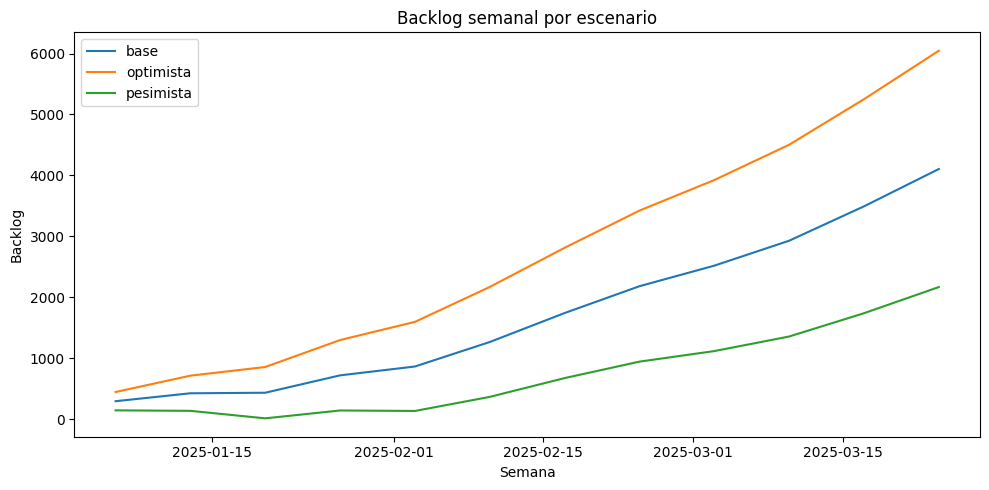

In [17]:
# 📈 Visualización: Backlog semanal por escenario
import matplotlib.pyplot as plt
backlog_week = df_results.groupby(['scenario', 'week'])['backlog'].sum().reset_index()
fig, ax = plt.subplots(figsize=(10,5))
for scen, g in backlog_week.groupby('scenario'):
    ax.plot(g['week'], g['backlog'], label=scen)
ax.set_title('Backlog semanal por escenario')
ax.set_xlabel('Semana'); ax.set_ylabel('Backlog')
ax.legend(); plt.tight_layout(); plt.show()

### 📈 Visualización de backlog semanal
Se grafica la evolución del backlog total por escenario para observar saturación y alivios en el tiempo.

- Eje Y: Unidades de backlog agregadas por semana.
- Comparabilidad: Las curvas permiten comparar carga acumulada entre escenarios.
- Uso: Detectar semanas críticas para ajustes de capacidad.

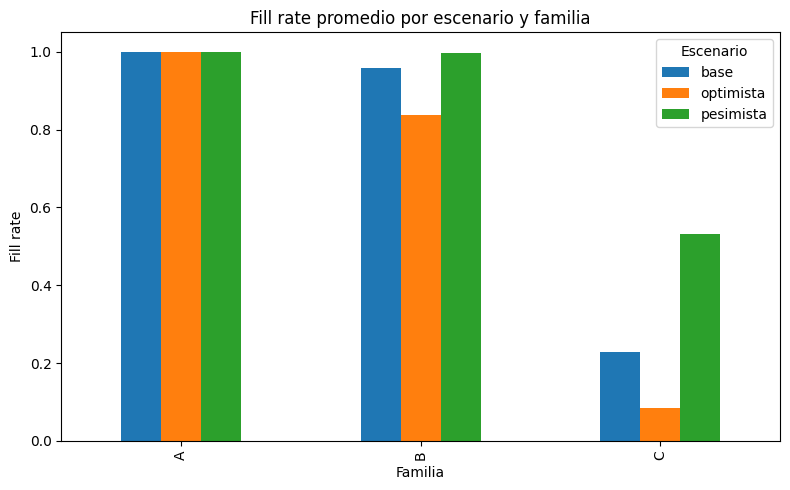

In [18]:
# 📊 Visualización: Fill rate promedio por escenario y familia
import matplotlib.pyplot as plt
pivot_fr = kpi.pivot(index='family', columns='scenario', values='fill_rate')
fig, ax = plt.subplots(figsize=(8,5))
pivot_fr.plot(kind='bar', ax=ax)
ax.set_title('Fill rate promedio por escenario y familia')
ax.set_xlabel('Familia'); ax.set_ylabel('Fill rate')
ax.legend(title='Escenario'); plt.tight_layout(); plt.show()

### 📊 Visualización de fill rate
Se comparan los niveles de servicio promedio por familia entre escenarios para evaluar cumplimiento contra objetivos.

- Rango: Valores en [0, 1].
- Objetivo: Referencia en `df_policies.fill_rate_target` por familia.
- Uso: Identificar escenarios/familias con brecha negativa y priorizar acciones.

In [19]:
# ✅ Sanidad básica
assert not df_results.empty, 'Resultados vacíos'
assert not kpi.empty, 'KPIs vacíos'
print('Notebook BA-02 listo: resultados y KPIs generados.')

Notebook BA-02 listo: resultados y KPIs generados.
